# 🏃 Inference Acceleration on CPUs

- Deep neural networks are usually quite slow – at least compared to other classic machine learning models
- We try to accelerate the inference on CPUs for XLM-RoBERTa with tricks like quantization


## Model

The model is a fine-tuned version of [xlm-roberta-base](https://huggingface.co/xlm-roberta-base) on the [Language Identification](https://huggingface.co/datasets/papluca/language-identification#additional-information) dataset:


In [1]:
model_name = "papluca/xlm-roberta-base-language-detection"

German text (with some English words as well) as example input:


In [2]:
text = "Rubber Soul ist das sechste Studioalbum der britischen Gruppe The Beatles."

## Baseline: Simple Pipeline

The most high-level thing to do is probably `transformers.pipeline()`.


In [3]:
import transformers

In [4]:
pipeline = transformers.pipeline("text-classification", model=model_name, tokenizer=model_name)


def simple_pipeline(text: str) -> str:
    # fire!
    prediction = pipeline(text)

    # return only the label as string
    return prediction[0]["label"]


simple_pipeline(text)

'de'

### Profiling

To evaluate inference time (in milliseconds), we classify the same input 1,000 times and calculate the mean, median and standard deviation.


In [5]:
from utils import Timer

In [6]:
num_loops = 1_000

In [7]:
timer = Timer(num_loops=num_loops)

In [8]:
timer.evaluate(simple_pipeline, text)

simple_pipeline: {'mean': 44.70298743247986, 'median': 44.76284980773926, 'stdev': 1.9920702926544707}


## Approach 1: DIY Preprocessing, Inference, Postprocessing

Going one step more low-level, we preprocess the input text ourselves, process it thorugh the model and translate the prediction into the most likely label.


In [9]:
from torch import Tensor
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)

In [11]:
def preprocess(text: str) -> Tensor:
    return tokenizer(text, return_tensors="pt")["input_ids"]


def inference(input_ids: Tensor) -> Tensor:
    return model.forward(input_ids).logits


def postprocess(logits: Tensor) -> str:
    return config.id2label[logits.argmax().item()]

### Tokenize Text


In [12]:
inputs = preprocess(text)
inputs

tensor([[     0,  65787,   1297,  99837,    443,    381,  87659,     67,  22968,
          54981,    122, 216357,     19,  54493,    581, 130904,      5,      2]])

### Process Through the Model


In [13]:
outputs = inference(inputs)
outputs

tensor([[-1.7941, -0.0125, -1.0825,  0.3778,  7.8346,  0.6406, -0.3162, -0.6920,
         -0.0727,  0.0403, -1.2121,  0.1262,  0.2210, -0.7516, -0.8402, -0.7351,
         -0.2303, -0.7274, -0.1624, -0.6116]], grad_fn=<AddmmBackward0>)

### Select the Most Likely Label


In [14]:
prediction = postprocess(outputs)
prediction

'de'

### Wrapping Everything in a Function


In [15]:
def preprocess_inference_postprocess(text: str):
    # tokenize text
    input_ids = preprocess(text)

    # fire!
    logits = inference(input_ids)

    # most likely label
    return postprocess(logits)

In [16]:
preprocess_inference_postprocess(text)

'de'

In [17]:
timer.evaluate(preprocess_inference_postprocess, text)

preprocess_inference_postprocess: {'mean': 46.65945553779602, 'median': 46.16427421569824, 'stdev': 2.562030245870282}


In [18]:
timer.summary()

,mean,median,stdev
simple_pipeline,44.702987,44.762850,1.99207
preprocess_inference_postprocess,46.659456,46.164274,2.56203


### Bottlenecks

To find out where the performance bottlenecks are (i.e. find out _what_ to optimize), we profile all of the three steps separately.


preprocess: {'mean': 0.0964055061340332, 'median': 0.09036064147949219, 'stdev': 0.021001382892959317}
inference: {'mean': 48.63945651054382, 'median': 46.106576919555664, 'stdev': 7.403134646609489}
postprocess: {'mean': 0.005352020263671875, 'median': 0.0050067901611328125, 'stdev': 0.005945669873304289}


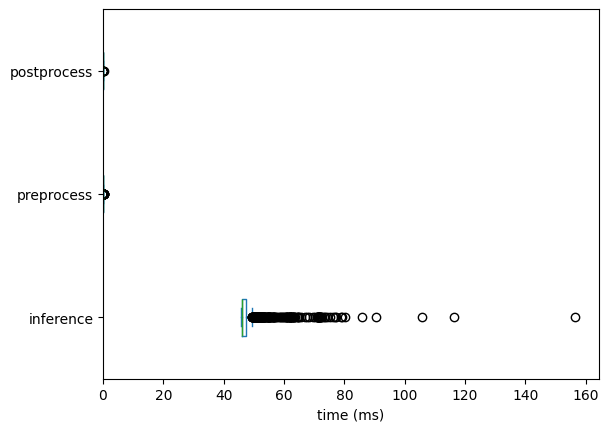

In [19]:
bottlenecks = Timer(num_loops=num_loops)

bottlenecks.evaluate(preprocess, text)
bottlenecks.evaluate(inference, inputs)
bottlenecks.evaluate(postprocess, outputs)

bottlenecks.plot()

# Approach 2: Simple Pipeline with ONNX model

From the [Optimum documentation](https://huggingface.co/docs/optimum/onnxruntime/concept_guides/onnx):

> ONNX is an open standard that defines a common set of operators and a common file format to represent deep learning models in a wide variety of frameworks, including PyTorch and TensorFlow. When a model is exported to the ONNX format, these operators are used to construct a computational graph (often called an intermediate representation) that represents the flow of data through the neural network.
>
> By exposing a graph with standardized operators and data types, **ONNX makes it easy to switch between frameworks**. For example, a model trained in PyTorch can be exported to ONNX format and then imported in TensorFlow (and vice versa).
>
> Where ONNX really shines is when it is coupled with a dedicated accelerator like ONNX Runtime, or ORT for short. **ORT provides tools to optimize the ONNX graph** through techniques like operator fusion and constant folding, and defines an interface to execution providers that allow you to run the model on different types of hardware.


We still use the `transformers.pipeline()` – but with an ONNX model.


In [20]:
from optimum.onnxruntime import ORTModelForSequenceClassification

In [21]:
onnx_model = ORTModelForSequenceClassification.from_pretrained(model_name, export=True)

Framework not specified. Using pt to export the model.
Using the export variant default. Available variants are:
    - default: The default ONNX variant.

***** Exporting submodel 1/1: XLMRobertaForSequenceClassification *****
Using framework PyTorch: 2.4.1+cu121
Overriding 1 configuration item(s)
	- use_cache -> False


In [22]:
pipeline = transformers.pipeline("text-classification", model=onnx_model, tokenizer=tokenizer)


def onnx_pipeline(text: str) -> str:
    # fire!
    prediction = pipeline(text)

    # return only the label as string
    return prediction[0]["label"]


onnx_pipeline(text)

'de'

In [23]:
timer.evaluate(onnx_pipeline, text)

onnx_pipeline: {'mean': 22.047638654708862, 'median': 22.12369441986084, 'stdev': 1.5162716948974961}


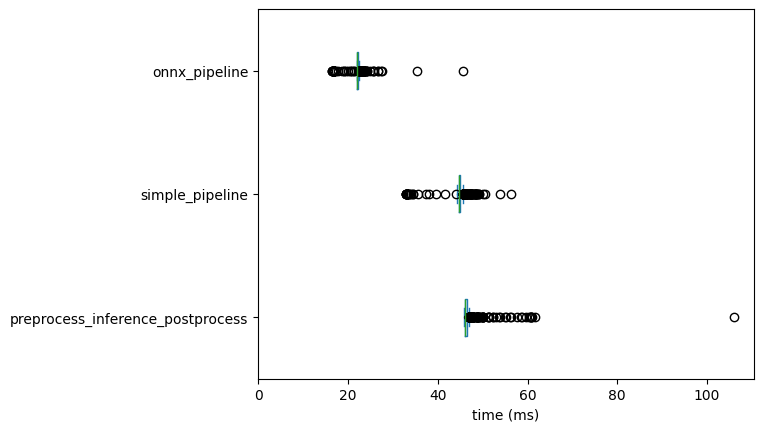

In [24]:
timer.plot()

In [25]:
timer.summary()

,mean,median,stdev
onnx_pipeline,22.047639,22.123694,1.516272
simple_pipeline,44.702987,44.762850,1.992070
preprocess_inference_postprocess,46.659456,46.164274,2.562030


## Approach 3: Inference Session with ONNX Runtime

Now we get rid of `transformers.pipeline()` and use the `onnxruntime` package (which is only ~13 MB!). Before ONNX, we used the PyTorch model – and PyTorch is ~900 MB.


We have to serialize the model to disk and load it as `InferenceSession`:


In [26]:
onnx_model.save_pretrained("onnx")

In [27]:
from onnxruntime import InferenceSession

In [28]:
session = InferenceSession("onnx/model.onnx")

In [29]:
import numpy as np

In [30]:
def preprocess(text: str) -> dict[str, np.ndarray]:
    inputs = tokenizer(text)
    return {
        "input_ids": np.array([inputs["input_ids"]]),
        "attention_mask": np.array([inputs["attention_mask"]]),
    }


def inference(inputs: dict[str, np.ndarray]) -> np.ndarray:
    return session.run(["logits"], inputs)[0]


def postprocess(logits: np.ndarray) -> str:
    return config.id2label[logits.argmax()]

In [31]:
def onnx_inference_session(text: str) -> str:
    # tokenize text
    inputs = preprocess(text)

    # fire!
    outputs = inference(inputs)

    # most likely label
    return postprocess(outputs)

In [32]:
onnx_inference_session(text)

'de'

In [33]:
timer.evaluate(onnx_inference_session, text)

onnx_inference_session: {'mean': 13.870740413665771, 'median': 13.345718383789062, 'stdev': 1.1826071679709649}


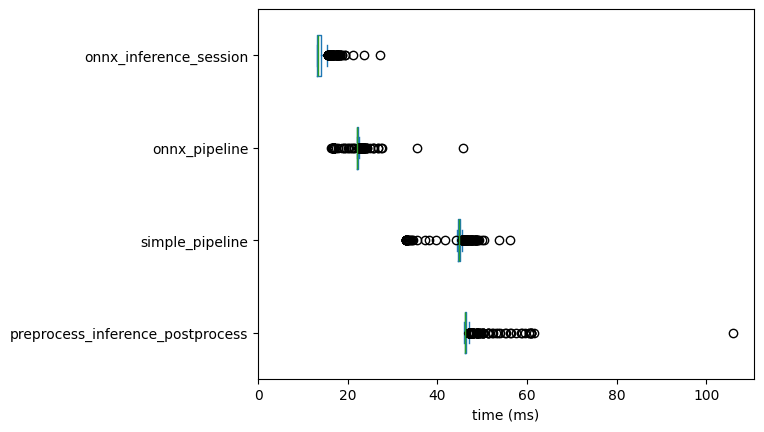

In [34]:
timer.plot()

## Approach 4: Optimization

We apply some optimizations now. There are a three different levels:

- `1`: basic optimizations
- `2`: basic and extended optimizations (incl. complex node fusions applied to the nodes, **making the resulting optimized graph hardware dependent**)
- `99`: all available optimizations including layout optimizations


### Basic Optimizations

- Constant folding: Statically computes parts of the graph that rely only on constant initializers
- Redundant node eliminations: Remove all redundant nodes without changing the graph structure
- Semantics-preserving node fusions: Fuse/fold multiple nodes into a single node


In [35]:
optimizations = {}

In [36]:
from optimum.onnxruntime import ORTModelForSequenceClassification
from optimum.onnxruntime.configuration import OptimizationConfig
from optimum.onnxruntime.optimization import ORTOptimizer

In [37]:
optimizer = ORTOptimizer.from_pretrained(onnx_model)
optimization_config = OptimizationConfig(optimization_level=1)

# optimize and serialize to disk
optimizer.optimize(save_dir="onnx", optimization_config=optimization_config)

Optimizing model...
Configuration saved in onnx/ort_config.json
Optimized model saved at: onnx (external data format: False; saved all tensor to one file: True)


PosixPath('onnx')

In [38]:
session = InferenceSession("onnx/model_optimized.onnx")

In [39]:
def onnx_optimized_1(text: str) -> str:
    # tokenize text
    inputs = preprocess(text)

    # fire!
    outputs = inference(inputs)

    # most likely label
    return postprocess(outputs)

In [40]:
median = timer.evaluate(onnx_optimized_1, text, return_median=True)
optimizations[median] = optimization_config

onnx_optimized_1: {'mean': 12.283594131469727, 'median': 11.81340217590332, 'stdev': 1.5893929901633386}


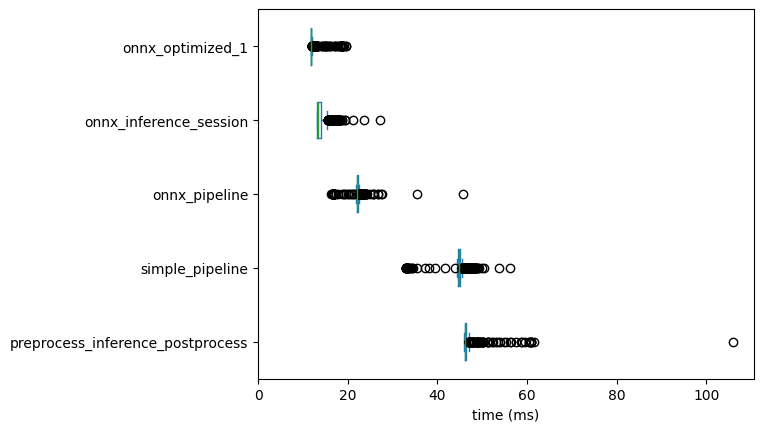

In [41]:
timer.plot()

### Both Basic and Extended Optimizations

- Complex node fusions (e.g. fusing the BERT embedding layer, layer normalization and attention mask length)
- Approximation


In [42]:
optimizer = ORTOptimizer.from_pretrained(onnx_model)
optimization_config = OptimizationConfig(optimization_level=2)

# optimize and serialize to disk
optimizer.optimize(save_dir="onnx", optimization_config=optimization_config)

Optimizing model...
Configuration saved in onnx/ort_config.json
Optimized model saved at: onnx (external data format: False; saved all tensor to one file: True)


PosixPath('onnx')

In [43]:
session = InferenceSession("onnx/model_optimized.onnx")

In [44]:
def onnx_optimized_2(text: str) -> str:
    # tokenize text
    inputs = preprocess(text)

    # fire!
    outputs = inference(inputs)

    # most likely label
    return postprocess(outputs)

In [45]:
median = timer.evaluate(onnx_optimized_2, text, return_median=True)
optimizations[median] = optimization_config

onnx_optimized_2: {'mean': 11.905151128768921, 'median': 11.83164119720459, 'stdev': 0.3487942464172585}


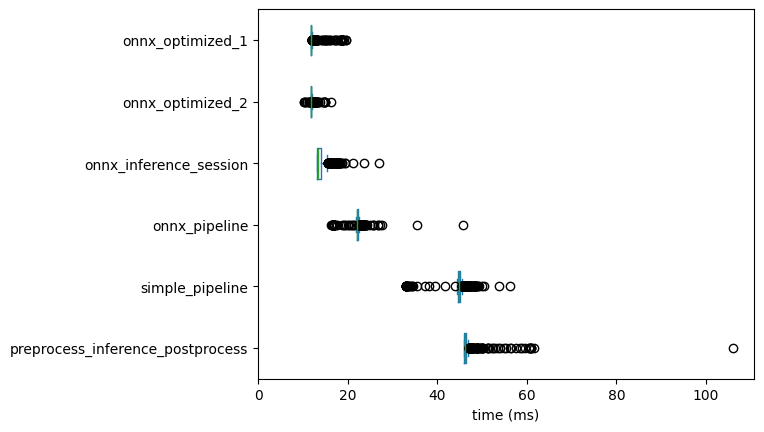

In [46]:
timer.plot()

### Layout Optimizations

- Changing the data layout (i.e. using the NCHWc layout instead of the NCHW layout)

#### WTF is NCHWc/NCHW?

- A way to store multidimensional arrays into memory
- NCHWc is one example of using data layout to improve spatial locality for a specific hardware target
- In this case it is convenient to have channel as the innermost dimension as it is often a power of two and larger than the vector width x86 CPUs (both AVX-2 and AVX-512)
- Note that this is **hardware target dependent**


In [47]:
optimizer = ORTOptimizer.from_pretrained(onnx_model)
optimization_config = OptimizationConfig(optimization_level=99)

# optimize and serialize to disk
optimizer.optimize(save_dir="onnx", optimization_config=optimization_config)

Optimizing model...
2024-10-30 18:34:14.551447934 [W:onnxruntime:, inference_session.cc:2039 Initialize] Serializing optimized model with Graph Optimization level greater than ORT_ENABLE_EXTENDED and the NchwcTransformer enabled. The generated model may contain hardware specific optimizations, and should only be used in the same environment the model was optimized in.
Configuration saved in onnx/ort_config.json
Optimized model saved at: onnx (external data format: False; saved all tensor to one file: True)


PosixPath('onnx')

In [48]:
session = InferenceSession("onnx/model_optimized.onnx")

In [49]:
def onnx_optimized_99(text: str) -> str:
    # tokenize text
    inputs = preprocess(text)

    # fire!
    outputs = inference(inputs)

    # most likely label
    return postprocess(outputs)

In [50]:
median = timer.evaluate(onnx_optimized_99, text, return_median=True)
optimizations[median] = optimization_config

onnx_optimized_99: {'mean': 12.25509762763977, 'median': 11.920452117919922, 'stdev': 1.4406915776358362}


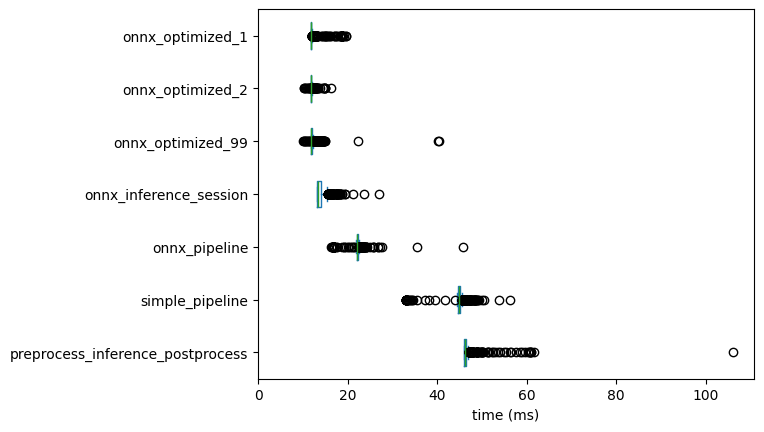

In [51]:
timer.plot()

In [52]:
timer.summary()

,mean,median,stdev
onnx_optimized_1,12.283594,11.813402,1.589393
onnx_optimized_2,11.905151,11.831641,0.348794
onnx_optimized_99,12.255098,11.920452,1.440692
onnx_inference_session,13.870740,13.345718,1.182607
onnx_pipeline,22.047639,22.123694,1.516272
simple_pipeline,44.702987,44.762850,1.992070
preprocess_inference_postprocess,46.659456,46.164274,2.562030


### Float32 to Float16

All weights and nodes are converted from float32 to float16.


In [53]:
optimizer = ORTOptimizer.from_pretrained(onnx_model)
optimization_config = OptimizationConfig(fp16=True)
optimizer.optimize(save_dir="onnx", optimization_config=optimization_config)

Optimizing model...
Configuration saved in onnx/ort_config.json
Optimized model saved at: onnx (external data format: False; saved all tensor to one file: True)


PosixPath('onnx')

In [54]:
session = InferenceSession("onnx/model_optimized.onnx")

In [55]:
def onnx_float16(text: str) -> str:
    # tokenize text
    inputs = preprocess(text)

    # fire!
    outputs = inference(inputs)

    # most likely label
    return postprocess(outputs)

In [56]:
timer.evaluate(onnx_float16, text)

onnx_float16: {'mean': 119.78574752807617, 'median': 119.28534507751465, 'stdev': 3.744365201957867}


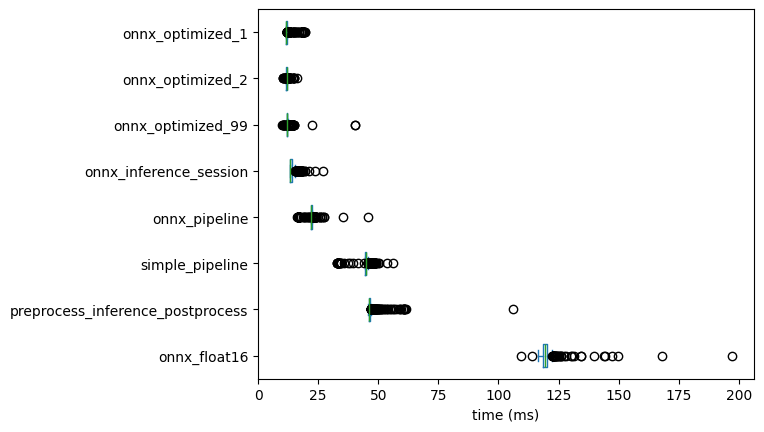

In [57]:
timer.plot()

### Why tho?

Many CPUs do not natively support the float16 type and have to calculate the float16 value first?


## Approach 4: Quantization

From the [Optimum documentation](https://huggingface.co/docs/optimum/main/en/concept_guides/quantization#quantization):

> Quantization is a technique to reduce the computational and memory cost of running inference by **representing the weights and activations with low-precision data types like 8-bit integer (INT8) instead of the usual 32-bit floating point (FP32)**. Reducing the number of bits means the resulting model requires **less memory storage**, and operations like matrix multiplication can be performed much **faster with integer arithmetic**. Remarkably, these performance gains can be realized with **little to no loss in accuracy**.


In [58]:
quantizations = {}

Using the best model so far:


In [59]:
optimizer = ORTOptimizer.from_pretrained(onnx_model)

# use best optimization
optimization_config = optimizations[min(optimizations)]

# optimize and serialize to disk
optimizer.optimize(save_dir="onnx", optimization_config=optimization_config)

Optimizing model...
Configuration saved in onnx/ort_config.json
Optimized model saved at: onnx (external data format: False; saved all tensor to one file: True)


PosixPath('onnx')

### AVX2

AVX2 expands most integer commands to 256 bits and introduces new instructions.


In [60]:
from pathlib import Path

import onnx
from optimum.onnxruntime import AutoQuantizationConfig, ORTQuantizer

In [61]:
quantizer = ORTQuantizer(Path("onnx/model_optimized.onnx"))
quantization_config = AutoQuantizationConfig.avx2(is_static=False)
quantizer.quantize(
    quantization_config, "onnx", extra_options={"DefaultTensorType": onnx.TensorProto.FLOAT}
)

Creating dynamic quantizer: QOperator (mode: IntegerOps, schema: u8/u8, channel-wise: True)
Quantizing model...
Saving quantized model at: onnx (external data format: False)
Configuration saved in onnx/ort_config.json


PosixPath('onnx')

In [62]:
session = InferenceSession("onnx/model_optimized_quantized.onnx")

In [63]:
def onnx_optimized_quantized_avx2(text: str) -> str:
    # tokenize text
    inputs = preprocess(text)

    # fire!
    outputs = inference(inputs)

    # most likely label
    return postprocess(outputs)

In [64]:
median = timer.evaluate(onnx_optimized_quantized_avx2, text, return_median=True)
quantizations[median] = quantization_config

onnx_optimized_quantized_avx2: {'mean': 5.583106279373169, 'median': 5.554914474487305, 'stdev': 0.20499636141114633}


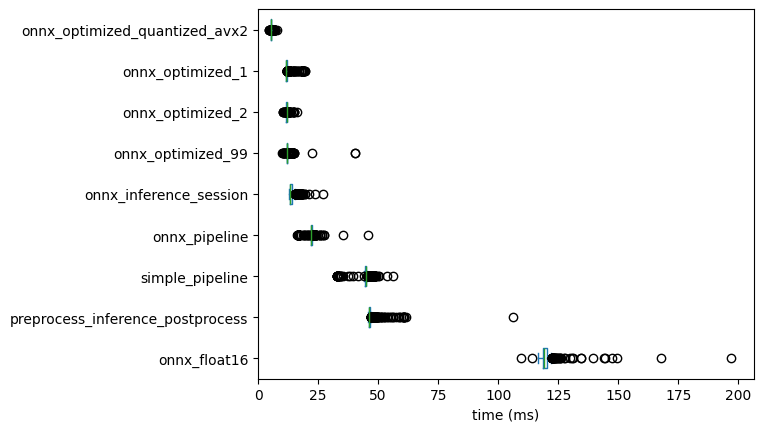

In [65]:
timer.plot()

### AVX-512

Advanced Vector Extensions 512 (AVX-512) is the collective name for a number of 512-bit SIMD x86 instruction set extensions.


In [66]:
quantizer = ORTQuantizer(Path("onnx/model_optimized.onnx"))
quantization_config = AutoQuantizationConfig.avx512(is_static=False)
quantizer.quantize(
    quantization_config, "onnx", extra_options={"DefaultTensorType": onnx.TensorProto.FLOAT}
)

Creating dynamic quantizer: QOperator (mode: IntegerOps, schema: u8/s8, channel-wise: True)
Quantizing model...
Saving quantized model at: onnx (external data format: False)
Configuration saved in onnx/ort_config.json


PosixPath('onnx')

In [67]:
session = InferenceSession("onnx/model_optimized_quantized.onnx")

In [68]:
def onnx_optimized_quantized_avx512(text: str) -> str:
    # tokenize text
    inputs = preprocess(text)

    # fire!
    outputs = inference(inputs)

    # most likely label
    return postprocess(outputs)

In [69]:
median = timer.evaluate(onnx_optimized_quantized_avx512, text, return_median=True)
quantizations[median] = quantization_config

onnx_optimized_quantized_avx512: {'mean': 5.548020362854004, 'median': 5.538344383239746, 'stdev': 0.18948561671113415}


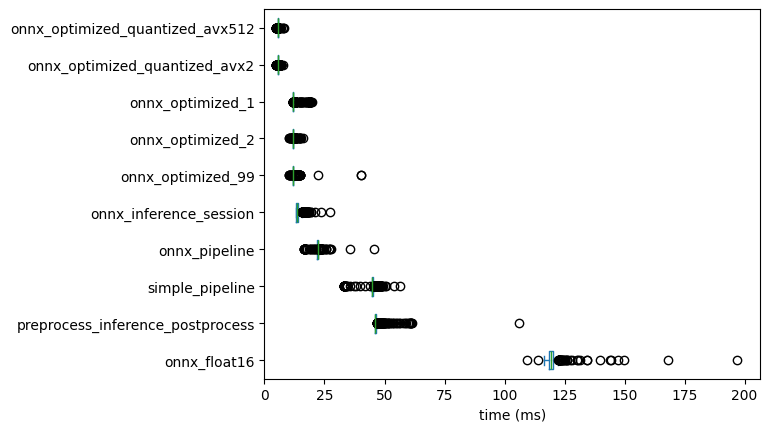

In [70]:
timer.plot()

### AVX-512 VNNI

AVX-512 Vector Neural Network Instructions (AVX512 VNNI) is an x86 extension, part of the AVX-512, designed to accelerate convolutional neural network-based algorithms.


In [71]:
quantizer = ORTQuantizer(Path("onnx/model_optimized.onnx"))
quantization_config = AutoQuantizationConfig.avx512_vnni(is_static=False)
quantizer.quantize(
    quantization_config, "onnx", extra_options={"DefaultTensorType": onnx.TensorProto.FLOAT}
)

Creating dynamic quantizer: QOperator (mode: IntegerOps, schema: u8/s8, channel-wise: True)
Quantizing model...
Saving quantized model at: onnx (external data format: False)
Configuration saved in onnx/ort_config.json


PosixPath('onnx')

In [72]:
session = InferenceSession("onnx/model_optimized_quantized.onnx")

In [73]:
def onnx_optimized_quantized_avx512_vnni(text: str) -> str:
    # tokenize text
    inputs = preprocess(text)

    # fire!
    outputs = inference(inputs)

    # most likely label
    return postprocess(outputs)

In [74]:
median = timer.evaluate(onnx_optimized_quantized_avx512_vnni, text, return_median=True)
quantizations[median] = quantization_config

onnx_optimized_quantized_avx512_vnni: {'mean': 8.118718385696411, 'median': 7.980823516845703, 'stdev': 1.008285363472563}


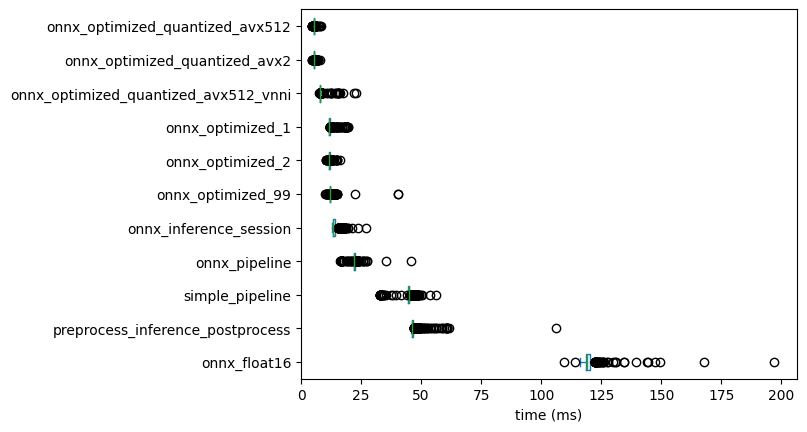

In [75]:
timer.plot()

In [76]:
timer.summary()

,mean,median,stdev
onnx_optimized_quantized_avx512,5.548020,5.538344,0.189486
onnx_optimized_quantized_avx2,5.583106,5.554914,0.204996
onnx_optimized_quantized_avx512_vnni,8.118718,7.980824,1.008285
onnx_optimized_1,12.283594,11.813402,1.589393
onnx_optimized_2,11.905151,11.831641,0.348794
onnx_optimized_99,12.255098,11.920452,1.440692
onnx_inference_session,13.870740,13.345718,1.182607
onnx_pipeline,22.047639,22.123694,1.516272
simple_pipeline,44.702987,44.762850,1.992070
preprocess_inference_postprocess,46.659456,46.164274,2.562030


## Approach 5: ONNX Inference Session Options as Hyperparameters

There are some options to configure the ONNX `InferenceSession`:

- `enable_cpu_mem_arena`: Enables the memory arena on CPU. Arena may pre-allocate memory for future usage. Default is `True`.
- `enable_mem_pattern`: Enable the memory pattern optimization. Default is `True`.
- `execution_mode`: Execution mode (sequential, parallel) of the inference. Default is `sequential`.
- `execution_order`: Execution order (topological, priority-based). Default is basic topological order.
- `inter_op_num_threads`: Number of threads used to parallelize the execution of the graph (across nodes). Default is `0`.
- `intra_op_num_threads`: Number of threads used to parallelize the execution within nodes. Default is `0`.
- `use_deterministic_compute`: Whether to use deterministic compute. Default is `False`.


In [77]:
from utils import ONNXSearchSpace

In [78]:
onnx_timer = Timer(num_loops=num_loops)

We use the fastest model so far:

In [79]:
quantizer = ORTQuantizer(Path("onnx/model_optimized.onnx"))

# use best quantization
quantization_config = quantizations[min(quantizations)]

# quantize and serialize to disk
quantizer.quantize(
    quantization_config, "onnx", extra_options={"DefaultTensorType": onnx.TensorProto.FLOAT}
)

Creating dynamic quantizer: QOperator (mode: IntegerOps, schema: u8/s8, channel-wise: True)
Quantizing model...
Saving quantized model at: onnx (external data format: False)
Configuration saved in onnx/ort_config.json


PosixPath('onnx')

In [80]:
search_space = ONNXSearchSpace()

print(f"We'll try {len(search_space)} different session option configurations")

We'll try 289 different session option configurations


We profile only the inference part now:


In [81]:
inputs = preprocess(text)
inputs

{'input_ids': array([[     0,  65787,   1297,  99837,    443,    381,  87659,     67,
          22968,  54981,    122, 216357,     19,  54493,    581, 130904,
              5,      2]]),
 'attention_mask': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [82]:
from tqdm import tqdm

results = {}

for options in tqdm(search_space):
    # load inference session with the given session options
    session = InferenceSession("onnx/model_optimized_quantized.onnx", options)

    median = onnx_timer.evaluate(inference, inputs, verbosity=0, return_median=True)
    results[median] = options

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [43:09<00:00,  8.96s/it]


In [83]:
print(f"Best time: {min(results)}")
print(f"Worst time: {max(results)}")

Best time: 5.315303802490234
Worst time: 14.996528625488281


In [84]:
session = InferenceSession("onnx/model_optimized_quantized.onnx", results[min(results)])


def onnx_optimized_quantized_best_options(text: str) -> str:
    # tokenize text
    inputs = preprocess(text)

    # fire!
    outputs = inference(inputs)

    # most likely label
    return postprocess(outputs)

In [85]:
timer.evaluate(onnx_optimized_quantized_best_options, text)

onnx_optimized_quantized_best_options: {'mean': 6.2122392654418945, 'median': 5.547642707824707, 'stdev': 1.093575184476011}


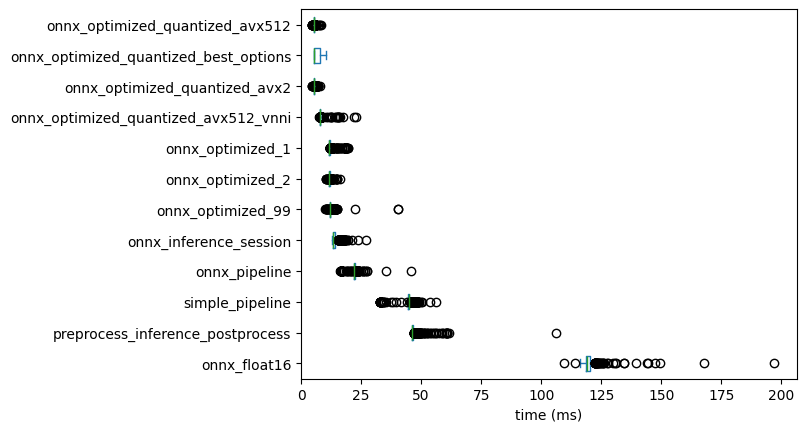

In [86]:
timer.plot()

In [87]:
timer.summary()

,mean,median,stdev
onnx_optimized_quantized_avx512,5.548020,5.538344,0.189486
onnx_optimized_quantized_best_options,6.212239,5.547643,1.093575
onnx_optimized_quantized_avx2,5.583106,5.554914,0.204996
onnx_optimized_quantized_avx512_vnni,8.118718,7.980824,1.008285
onnx_optimized_1,12.283594,11.813402,1.589393
onnx_optimized_2,11.905151,11.831641,0.348794
onnx_optimized_99,12.255098,11.920452,1.440692
onnx_inference_session,13.870740,13.345718,1.182607
onnx_pipeline,22.047639,22.123694,1.516272
simple_pipeline,44.702987,44.762850,1.992070


In [88]:
print(f"Times: {round(timer.baseline['median'])}ms vs. {round(timer.best_time['median'])}ms")
print(f"That's factor {round(timer.baseline['median'] / timer.best_time['median'])}!")

Times: 45ms vs. 6ms
That's factor 8!


## What About Accuracy?

We completely ignored the quality of the optimized and quantized model's predictions. In theory, quantization for example might lead to a loss in accuracy.


In [89]:
import random

from datasets import load_dataset

In [90]:
dataset = load_dataset("papluca/language-identification")

test_set = random.sample(list(dataset["test"]), 1000)

In [91]:
pipeline = transformers.pipeline("text-classification", model=model_name, tokenizer=model_name)


def slow(text: str) -> str:
    # fire!
    prediction = pipeline(text)

    # return only the label as string
    return prediction[0]["label"]

In [92]:
session = InferenceSession("onnx/model_optimized_quantized.onnx")


def fast(text: str) -> str:
    # tokenize text
    inputs = preprocess(text)

    # fire!
    outputs = inference(inputs)

    # most likely label
    return postprocess(outputs)

In [93]:
slow_predictions = [slow(record["text"]) for record in tqdm(test_set, desc="Slow")]
fast_predictions = [fast(record["text"]) for record in tqdm(test_set, desc="Fast")]

Fast: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.07it/s]


In [94]:
from sklearn.metrics import classification_report

In [95]:
report_slow = classification_report(
    [record["labels"] for record in test_set], slow_predictions, output_dict=True
)
report_fast = classification_report(
    [record["labels"] for record in test_set], fast_predictions, output_dict=True
)

In [96]:
for key in report_slow:
    if isinstance(report_slow[key], dict):
        print(key)
        print("slow:", {k: round(v, 1) for k, v in report_slow[key].items()})
        print("fast:", {k: round(v, 1) for k, v in report_fast[key].items()})
        print("\n")

ar
slow: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 52.0}
fast: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 52.0}


bg
slow: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 52.0}
fast: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 52.0}


de
slow: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 60.0}
fast: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 60.0}


el
slow: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 54.0}
fast: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 54.0}


en
slow: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 43.0}
fast: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 43.0}


es
slow: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 43.0}
fast: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 43.0}


fr
slow: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 48.0}
fast:

# Conclusion

Pros:

- Obviously speed
- User experience
- Lightweight dependency
-

Cons:

- Hardware dependent optimizations (optional though)
- Accuracy loss (minimal though)
